In [119]:
from Code_for_the_files.Kalman_General import *
from scipy.io import loadmat,savemat
import pickle

In [4]:
c1 = 10
c2 = 10
c3 = 0.5
c4 = 0
c5 = 0.5
k1 = 1000
k2 = 1
k3 = 1000
k4 = 0.04


Omega = 10

c1_tilde = c1 / Omega
c2_tilde = c2 / Omega
c3_tilde = c3 * Omega
c4_tilde = c4 / Omega
c5_tilde = c5
k1_tilde = k1 / Omega
k2_tilde = k2 / Omega
k3_tilde = k3 / Omega
k4_tilde = k4

T = 1

z10 = 0
z20 = 0
x10 = 0


In [5]:
# The network structure
species_names = ['z1', 'z2', 'x1']
stoichiometric_matrix = np.array([[1, 0, -1, 0, 0], [0, 1, -1, 0, 0], [0, 0, 0, 1, -1]])
parameters_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'k1', 'k2', 'k3', 'k4']
parameter_values = {'c1': c1, 'c2': c2, 'c3': c3, 'c4': c4, 'c5': c5, 'k1': k1, 'k2': k2, 'k3': k3, 'k4': k4}
reaction_names = ['z1 prod.', 'z2 prod.', 'z1,z2 deg.', 'prot prod.', 'prot deg.']
propensities = [
    lambda c1: c1,
    lambda c2: c2,
    lambda c3, z1, z2: c3*z1*z2,
    lambda c4, k1, k2, k3, k4, z1, z2: c4+(k3*(z1/k1))/(k4+(z1/k1)+(z2/k2)),
    lambda c5, x1: c5*x1
]

observable_species = ['x1']
range_of_species = pd.DataFrame({'min': [0, 0], 'max': [500, 500]}, index=['z1', 'z2'])

range_of_parameters = pd.DataFrame([[c1, c1], [c2, c2], [c3, c3], [c4, c4], [c5, c5], [k1, k1], [k2, k2], [k3, k3], [k4, k4]], index=parameters_names, columns=['min', 'max'])
discretization_size_parameters = pd.DataFrame([1, 1, 1, 1, 1, 1, 1, 1, 1], index=parameters_names)

CF_not_scaled = CRNForContinuousTimeFiltering(stoichiometric_matrix=stoichiometric_matrix,
                                              species_names=species_names,
                                              parameters_names=parameters_names,
                                              reaction_names=reaction_names,
                                              propensities=propensities,
                                              observable_species=observable_species,
                                              range_of_species=range_of_species,
                                              range_of_parameters=range_of_parameters,
                                              discretization_size_parameters=discretization_size_parameters)

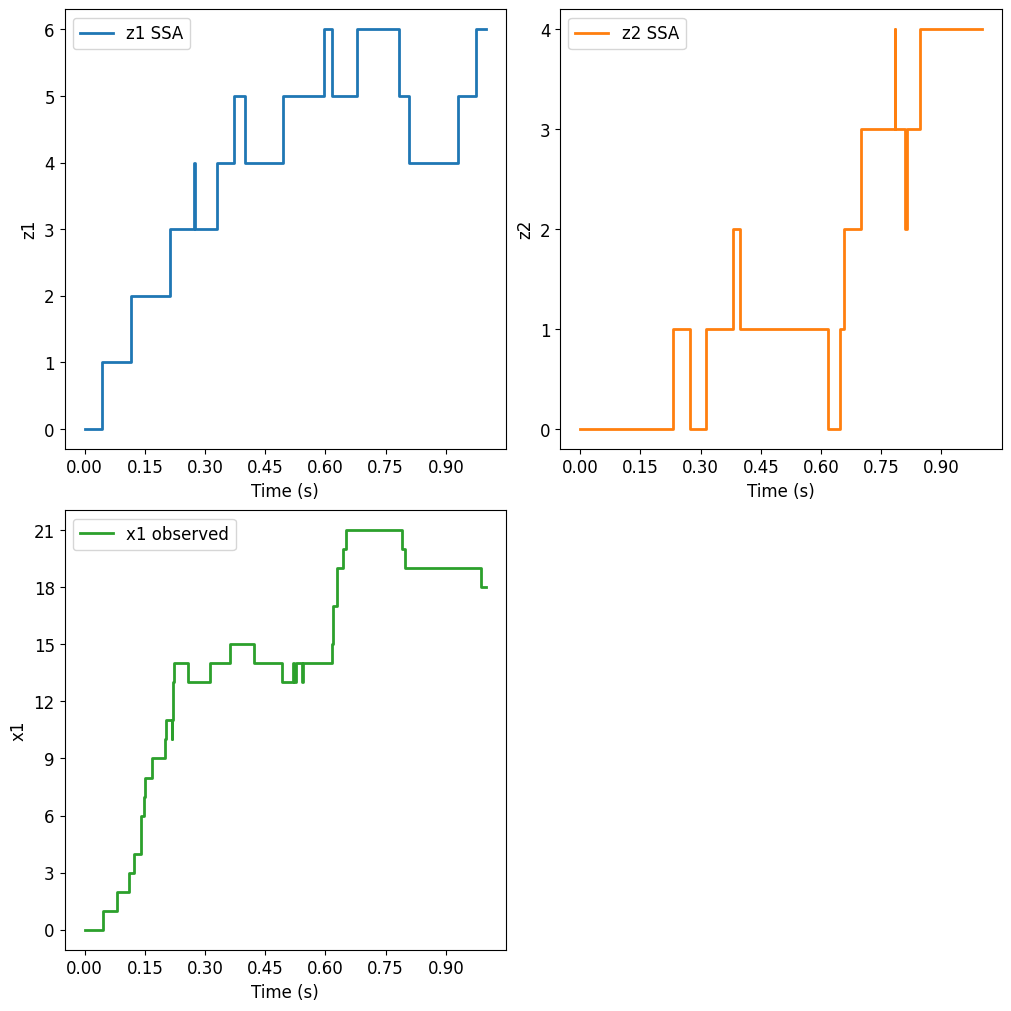

In [88]:
# Define initial conditions
initial_conditions = {'z1': z10, 'z2': z20, 'x1': x10}  # Define initial values based on the network
# Generate a single SSA trajectory and plot hidden and observed species
species_data, observed_data, time_list, time_list_1 = generate_and_plot_ssa(CF_not_scaled, parameter_values, initial_conditions, Omega)

In [103]:
hidden_species = [species for species in species_names if species not in observable_species]
# Extract hidden species data
hidden_species_data = {species: species_data[species] for species in hidden_species}
hidden_trajectories = np.array([hidden_species_data[species] for species in hidden_species]).T

In [115]:
# Observations
observations = [
    {'time': time_list_1, 'state': np.array([observed_data[species] for species in observable_species]).T}
]

N = 1001
# Running Kalman Filter
rho = 0.013
initial_conditions_1 = {
    'hat_z_0': [z10, z20, x10],
    'R_0': np.zeros((3, 3)),
    'species_values': {'z1': z10, 'z2': z20, 'x1': x10}
}
parameter_values_tilde = {'c1': c1_tilde, 'c2': c2_tilde, 'c3': c3_tilde, 'c4': c4_tilde, 'c5': c5_tilde, 'k1': k1_tilde, 'k2': k2_tilde, 'k3': k3_tilde, 'k4': k4_tilde}
observation_func = lambda z1, z2, x1: x1

common_time_points, hat_z_t_trajectory, R_t_trajectory, bar_z_t_trajectory = kalman_filter(
    initial_conditions_1, observations, parameter_values_tilde, propensities, stoichiometric_matrix, observation_func, Omega, rho, N
)

# Running Extended Kalman Filter
initial_conditions_2 = {
    'hat_z_0': [z10, z20, x10],
    'R_0': np.eye(3) * 1e-6,
    'species_values': {'z1': z10, 'z2': z20, 'x1': x10}
}
common_time_points_1, hat_z_t_trajectory_1, R_t_trajectory_1 = extended_kalman_filter(
    initial_conditions_2, observations, parameter_values_tilde, propensities, stoichiometric_matrix, observation_func, Omega, rho, N
)

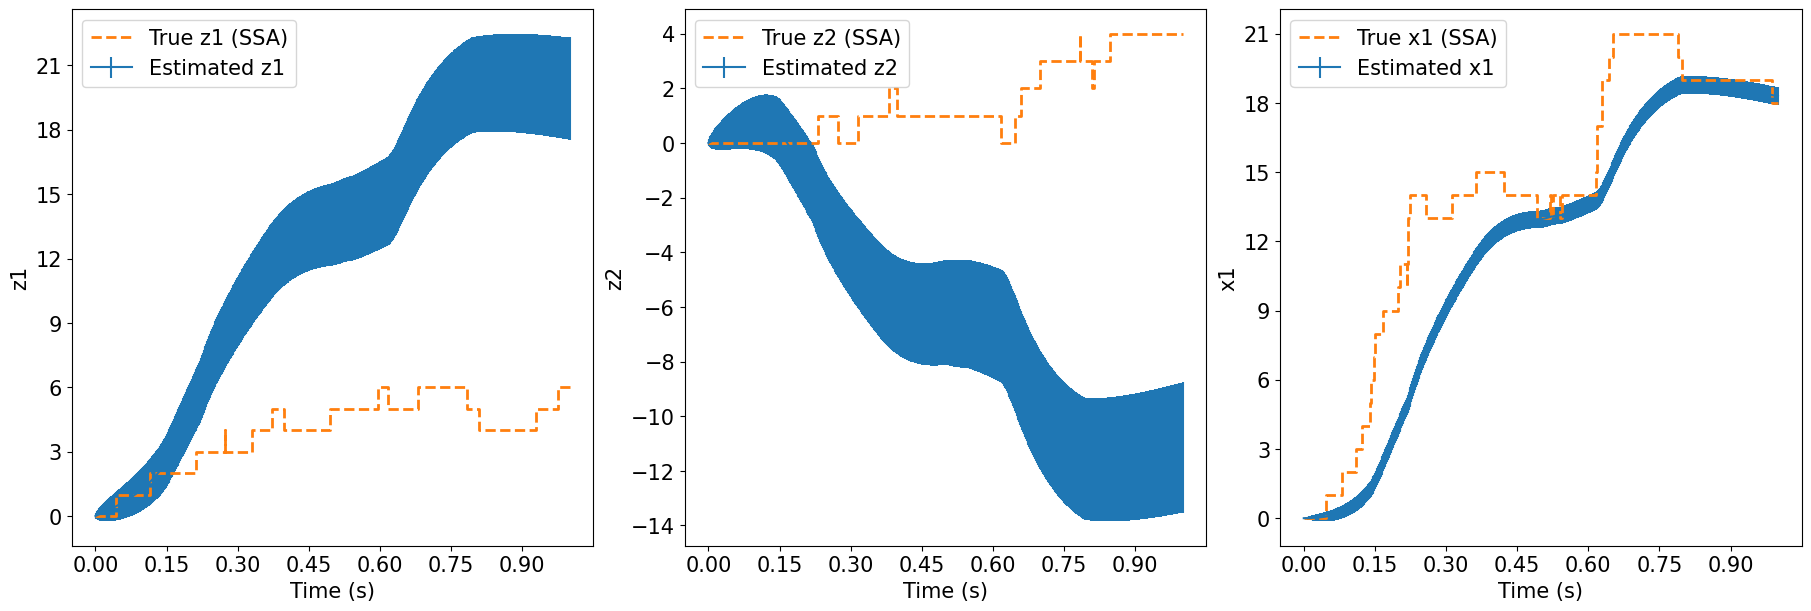

In [116]:
true_trajectories = [species_data[species] for species in initial_conditions.keys()]
plot_filters_results(np.linspace(0, time_list_1[-1], N), hat_z_t_trajectory, R_t_trajectory, time_list, true_trajectories, list(initial_conditions.keys()))

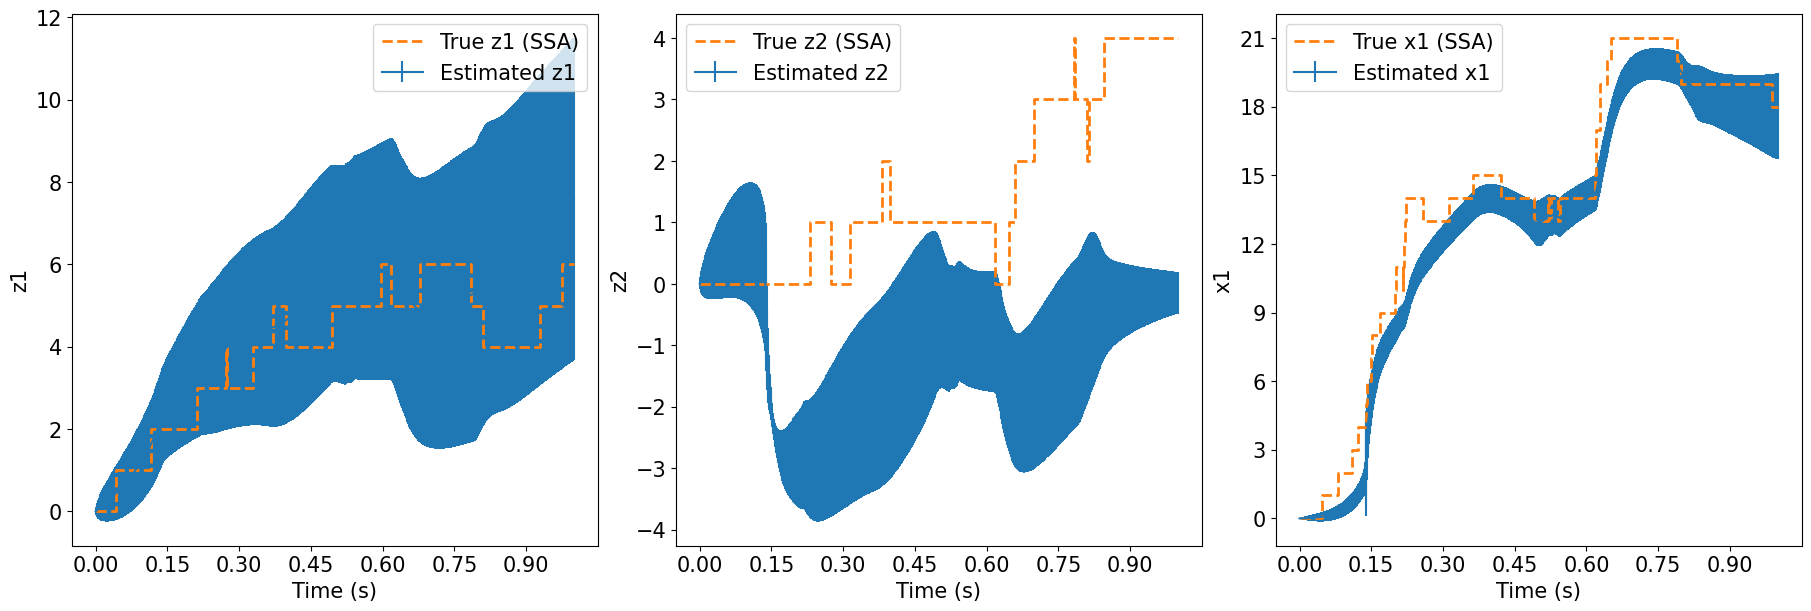

In [117]:
true_trajectories = [species_data[species] for species in initial_conditions.keys()]
plot_filters_results(np.linspace(0, time_list_1[-1], N), hat_z_t_trajectory_1, R_t_trajectory_1, time_list, true_trajectories, list(initial_conditions.keys()))

In [99]:
# Preparing data for saving for Matlab
mat_data = {
    'initial_conditions': initial_conditions,
    'parameter_values': parameter_values,
    'time_of_observations': observations[0]['time'],
    'state_sequence': observations[0]['state'],
    'observation_func': 'x1',
    'time_list': time_list,
    'hidden_trajectories': hidden_trajectories,
    'common_time_points': common_time_points,
}

# Saving data to a .mat file
savemat('data_for_matlab_1.mat', mat_data)

In [121]:
# Preparing data for saving for Python
python_data = {
    'initial_conditions': initial_conditions,
    'time_of_observations': observations[0]['time'],
    'state_sequence': observations[0]['state'],
    'observed_data': observed_data,
    'time_list': time_list,
    'true_trajectories': true_trajectories,
    'hidden_trajectories': hidden_trajectories,
    'common_time_points': common_time_points,
}
# Saving the same data to a .pkl file
with open('data_for_python.pkl', 'wb') as pkl_file:
    pickle.dump(python_data, pkl_file)

